# Tutorial 1 - Periodontal data (Visium HD + CODEX)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *

config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Periodontal'

In [4]:
adata1_rna = sc.read_h5ad(os.path.join(file_path,'section1/adata_rna_s1.h5ad'))
adata2_rna = sc.read_h5ad(os.path.join(file_path,'section2/adata_rna_s2.h5ad'))
adata2_adt = sc.read_h5ad(os.path.join(file_path,'section2/adata_protein_s2.h5ad'))

In [5]:
adata1_rna, adata2_rna,adata2_adt

(AnnData object with n_obs × n_vars = 190191 × 18085
     obs: 'in_tissue'
     var: 'gene_ids', 'feature_types', 'genome'
     obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2', 'transformed_pxl_loc',
 AnnData object with n_obs × n_vars = 213491 × 18085
     var: 'gene_ids', 'feature_types', 'genome'
     obsm: 'pxl_loc', 'spatial', 'spatial2', 'transformed_pxl_loc',
 AnnData object with n_obs × n_vars = 213491 × 26
     obs: 'gene_clusters'
     obsm: 'Protein_pca', 'pxl_loc', 'spatial', 'spatial2', 'transformed_pxl_loc')

In [6]:
adata1_rna.var_names_make_unique()
adata2_rna.var_names_make_unique()

In [7]:
adata1_he = sc.AnnData(X=adata1_rna.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata1_rna.obsm['spatial'].copy()
adata1_he

AnnData object with n_obs × n_vars = 190191 × 2048
    obsm: 'spatial'

## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [8]:
data_dict = {
        'RNA': [adata1_rna, adata2_rna],
        'HE': [adata1_he, None],
        'Protein': [None, adata2_adt],
    }

In [9]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, hvg_num=3000)

-------- Processing shared modality RNA across sections --------
Running Harmony for RNA


2025-05-28 21:44:54,976 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-28 21:45:15,325 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-28 21:45:19,172 - harmonypy - INFO - Iteration 1 of 10
2025-05-28 21:48:36,628 - harmonypy - INFO - Iteration 2 of 10
2025-05-28 21:51:49,795 - harmonypy - INFO - Iteration 3 of 10
2025-05-28 21:55:16,506 - harmonypy - INFO - Iteration 4 of 10
2025-05-28 21:58:21,618 - harmonypy - INFO - Iteration 5 of 10
2025-05-28 22:01:27,470 - harmonypy - INFO - Iteration 6 of 10
2025-05-28 22:04:57,927 - harmonypy - INFO - Iteration 7 of 10
2025-05-28 22:08:33,997 - harmonypy - INFO - Iteration 8 of 10
2025-05-28 22:11:53,627 - harmonypy - INFO - Iteration 9 of 10
2025-05-28 22:15:17,767 - harmonypy - INFO - Iteration 10 of 10
2025-05-28 22:18:10,557 - harmonypy - INFO - Stopped before convergence


-------- Processing unique modality HE for section 1 --------
-------- Processing unique modality Protein for section 2 --------
Extracting spatial location for section 1
Extracting spatial location for section 2


## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training.

In [10]:
Linkage_indicator = {
        ('s1', 's2'): [('RNA', 'RNA')]
    }

## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [11]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['RNA', 'HE', 'Protein']
-------- Encoder description --------
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [Protein]: Input 20 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → Protein]: [128, 512, 512, 128]
Predictor [Protein → RNA]: [128, 512, 512, 128]
Using device: cuda:0


In [17]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator, n_x=2, n_y=1)

-------- Running Sub-graph training mode, n_x is 2, n_y is 1 --------
Splitting section [s1] into 2 x 1 subgraphs
Splitting RNA in section s1...
Splitting HE in section s1...
Splitting section [s2] into 2 x 1 subgraphs
Splitting RNA in section s2...
Splitting Protein in section s2...
Computing linkage between [RNA] (s1-0) and [RNA] (s2-0)
Computing linkage between [RNA] (s1-0) and [RNA] (s2-1)
Computing linkage between [RNA] (s1-1) and [RNA] (s2-0)
Computing linkage between [RNA] (s1-1) and [RNA] (s2-1)
Model moved to cuda:0!
---------------- Constructing Full Graph ----------------
-------- Constructing full spatial graph for s1 --------
 Constructing full feature graph for [s1 - RNA]...
 Constructing full feature graph for [s1 - HE]...
-------- Constructing full spatial graph for s2 --------
 Constructing full feature graph for [s2 - RNA]...
 Constructing full feature graph for [s2 - Protein]...
---------------- Graph Construction in Subgraph Level ----------------
-------- Construct

Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [13:20<00:00,  1.33s/it]


 Running Evaluation...
Missing modality [Protein] in Section [s1]
Using predictor [RNA → Protein] to recover missing embedding...
Missing modality [HE] in Section [s2]
Using predictor [RNA → HE] to recover missing embedding...
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Periodontal


## Perform clustering and visualization

Perform joint clustering...


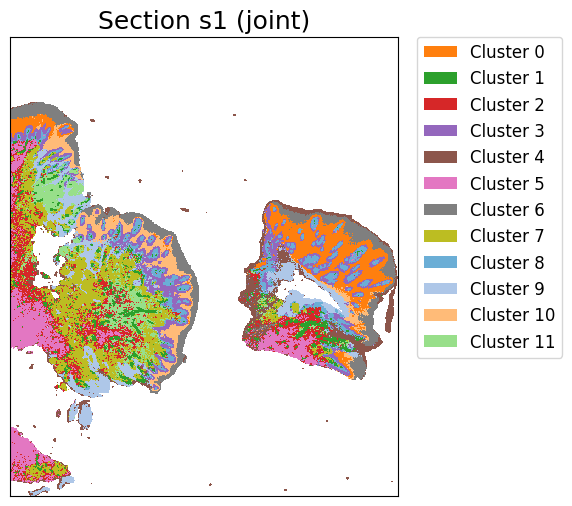

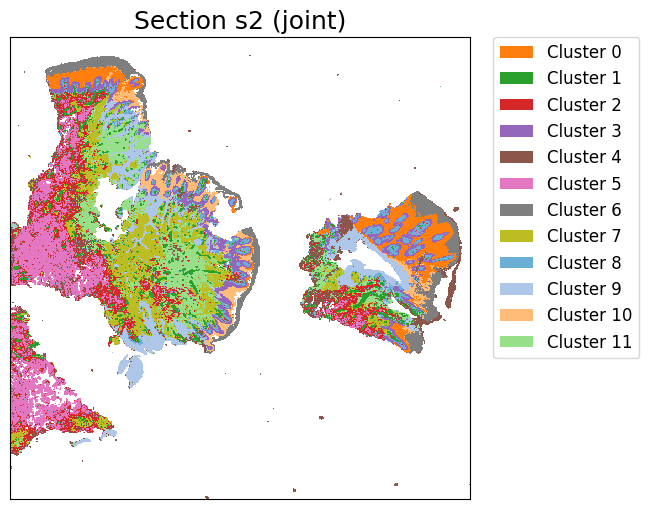

In [18]:
color_map =  [[255,127,14],[44,160,44],[214,39,40],[148,103,189],
              [140,86,75],[227,119,194],[127,127,127],[188,189,34],
             [107,174,214] ,[174,199,232],[255,187,120],[152,223,138],
              [255,152,150],[197,176,213],[196,156,148],[247,182,210],
              [199,199,199],[219,219,141],[158,218,229], [137,69,133],
              [31, 119, 180],[135, 206, 250]]

cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=12,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 colormap = color_map, 
                                                 dpi = 500,
                                                 figscale = 120)

## Predict CODEX data for section1

In [19]:
adata1_protein_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's1',
    target_modality = 'Protein',
    K_num=500,
    target_molecules='All',
    )

Using modality [RNA] in section [s1] as spatial/obs reference
[Protein] exists in ['s2'], which will be used as source data section


In [21]:
adata1_protein_predicted_norm = create_normalized_adata(adata1_protein_predicted)

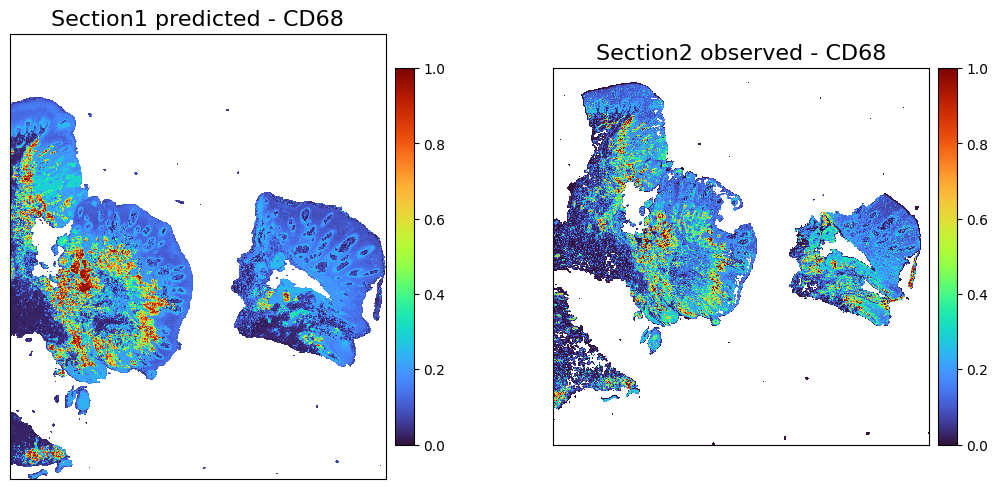

In [22]:
chosed_protein = 'CD68'
adata_truncate = truncate_gene_expression_smartclip(adata2_adt, chosed_protein, lower=0, upper=99)
adata_truncate_norm = create_normalized_adata(adata_truncate)

plot_marker_comparison_superpixel(
    chosed_protein,
    adata1_protein_predicted_norm,
    adata_truncate_norm,
    section1_label = 'Section1 predicted',
    section2_label = 'Section2 observed',
    basis = 'spatial',
    colormap = "turbo",
    figscale = 120,
    dpi = 500)
        


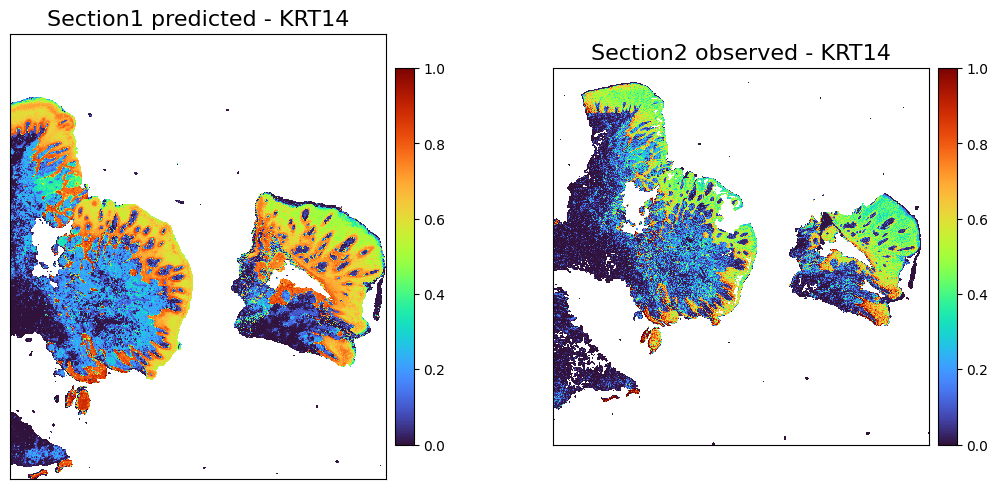

In [23]:
chosed_protein = 'KRT14'
adata_truncate = truncate_gene_expression_smartclip(adata2_adt, chosed_protein, lower=0, upper=99)
adata_truncate_norm = create_normalized_adata(adata_truncate)

plot_marker_comparison_superpixel(
    chosed_protein,
    adata1_protein_predicted_norm,
    adata_truncate_norm,
    section1_label = 'Section1 predicted',
    section2_label = 'Section2 observed',
    basis = 'spatial',
    colormap = "turbo",
    figscale = 120,
    dpi = 500)
        


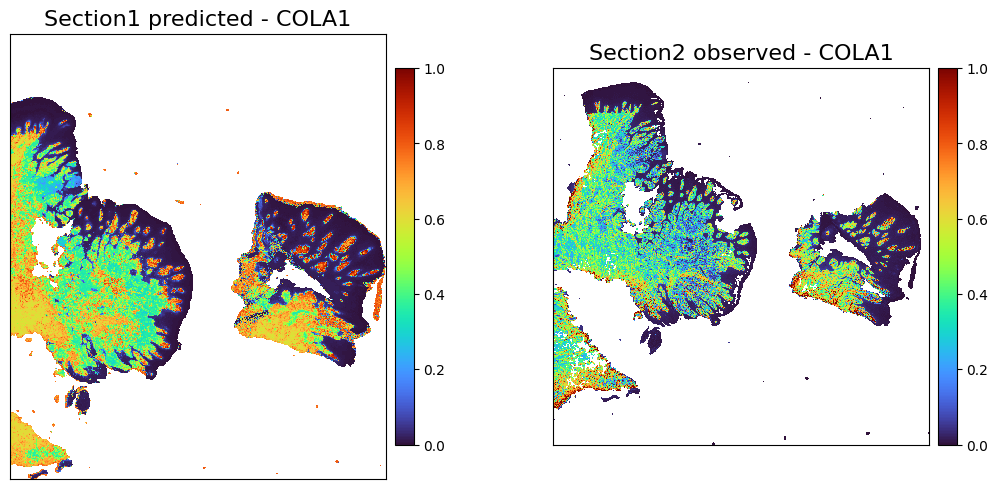

In [24]:
chosed_protein = 'COLA1'
adata_truncate = truncate_gene_expression_smartclip(adata2_adt, chosed_protein, lower=0, upper=99)
adata_truncate_norm = create_normalized_adata(adata_truncate)

plot_marker_comparison_superpixel(
    chosed_protein,
    adata1_protein_predicted_norm,
    adata_truncate_norm,
    section1_label = 'Section1 predicted',
    section2_label = 'Section2 observed',
    basis = 'spatial',
    colormap = "turbo",
    figscale = 120,
    dpi = 500)
        
